# 2. Emotioni Estimate Model - YOLOv5l

In [6]:
import os
import shutil
import time
import zipfile
import json
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

from PIL import Image
from PIL import ImageFile
import albumentations as A
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000
from tqdm import tqdm
tqdm.pandas()

## 1. Extra Dataset
- 측면, 밝기 조절 등 추가 어노테이션 적용한 데이터 구축 (Train 4)  
- 라벨링 수고를 덜기 위해, 앵커 박스로 크롭한 이미지 저장

In [24]:
# ROOT dir
EXTRA_ROOT = r"E:\한국인 감정인식을 위한 복합 영상\Training"

# Load Json data
json_dir = [j for j in os.listdir(os.path.join(EXTRA_ROOT, "label_json"))]
json_df = []
for json_data in json_dir:
    json_data = os.path.join(EXTRA_ROOT, "label_json", json_data)
    with open(json_data) as jFile:
        json_df.append(pd.DataFrame(json.load(jFile)))
json_df = pd.concat(json_df, axis=0).reset_index(drop=True)

# img data
img_df = pd.DataFrame({"PATH":[img for img in os.listdir(os.path.join(EXTRA_ROOT, "images"))]})

# extra df
extra_mapping_df = pd.merge(
    left=img_df, right=json_df, how="inner",
    left_on=["PATH"], right_on=["filename"]
)[["PATH", "gender", "age", "faceExp_uploader", "annot_A"]]

#### Annotate 정보 가져오기

In [25]:
def get_Annot(annot):
    annot = dict(annot)
    return dict(annot["boxes"])
def get_maxX(annot): return annot["maxX"]
def get_maxY(annot): return annot["maxY"]
def get_minX(annot): return annot["minX"]
def get_minY(annot): return annot["minY"]

extra_mapping_df["annot_A"] = extra_mapping_df["annot_A"].apply(get_Annot)
extra_mapping_df["A_maxX"] = extra_mapping_df["annot_A"].apply(get_maxX)
extra_mapping_df["A_maxY"] = extra_mapping_df["annot_A"].apply(get_maxY)
extra_mapping_df["A_minX"] = extra_mapping_df["annot_A"].apply(get_minX)
extra_mapping_df["A_minY"] = extra_mapping_df["annot_A"].apply(get_minY)

#### Normalization

In [5]:
def normalization(cols): return float(cols[0]) / float(cols[1])

# 원본 가로
extra_mapping_df["O_W"] = extra_mapping_df["SIZE"].apply(lambda s: str(s).strip("(|)").split(",")[0])
# 원본 가로
extra_mapping_df["O_H"] = extra_mapping_df["SIZE"].apply(lambda s: str(s).strip("(|)").split(",")[1])
extra_mapping_df["nor_A_maxX"] = extra_mapping_df[["A_maxX", "O_W"]].apply(normalization, axis=1)
extra_mapping_df["nor_A_maxY"] = extra_mapping_df[["A_maxY", "O_H"]].apply(normalization, axis=1)
extra_mapping_df["nor_A_minX"] = extra_mapping_df[["A_minX", "O_W"]].apply(normalization, axis=1)
extra_mapping_df["nor_A_minY"] = extra_mapping_df[["A_minY", "O_H"]].apply(normalization, axis=1)

#### Calculate X, Y, W, H

In [6]:
def get_XorY(cols): return (cols[0]+cols[1])/2.0
def get_WorH(cols): return cols[1] - cols[0]

extra_mapping_df["AX"] = extra_mapping_df[["nor_A_minX", "nor_A_maxX"]].apply(get_XorY, axis=1)
extra_mapping_df["AY"] = extra_mapping_df[["nor_A_minY", "nor_A_maxY"]].apply(get_XorY, axis=1)
extra_mapping_df["AW"] = extra_mapping_df[["nor_A_minX", "nor_A_maxX"]].apply(get_WorH, axis=1)
extra_mapping_df["AH"] = extra_mapping_df[["nor_A_minY", "nor_A_maxY"]].apply(get_WorH, axis=1)

#### Crop 및 사이즈 조절

In [35]:
# 원본 이미지 사이즈 가져오기 및 크롭, 사이즈 조절
def get_size_and_crop_640x640(cols):
    path, maxX, maxY, minX, minY = cols
    save_path = os.path.join(EXTRA_ROOT, "Crop640", path)
    path = os.path.join(EXTRA_ROOT, "images", path)
    try:
        img = Image.open(path)
        osize = img.size # 원본 이미지 사이즈
        crop_img = img.crop((minX, minY, maxX, maxY))
        crop_img = crop_img.resize((640, 640))
        crop_img.save(save_path) # Crop 이미지 저장
        return osize
    except: print(path)
    
extra_mapping_df["SIZE"] = extra_mapping_df[["PATH", "A_maxX", "A_maxY", "A_minX", "A_minY"]].progress_apply(get_size_and_crop_640x640, axis=1)

 25%|██▌       | 20906/83072 [59:32<2:58:28,  5.81it/s] c:\Users\spec3\anaconda3\envs\NN\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
 26%|██▌       | 21196/83072 [1:00:22<3:02:54,  5.64it/s]c:\Users\spec3\anaconda3\envs\NN\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 83072/83072 [3:36:48<00:00,  6.39it/s]   


#### 스플릿 및 증강

In [5]:
TRAIN_SIZE = 8856
VAL_SIZE = 2214

# 이상치 제거
cols = ["nor_A_minX", "nor_A_minY", "nor_A_maxX", "nor_A_maxY"]
for col in cols:
    extra_mapping_df = extra_mapping_df[extra_mapping_df[col]<1]
    extra_mapping_df = extra_mapping_df[extra_mapping_df[col]>0]

label_dict = {"기쁨":0, "당황":1, "불안":1, "분노":2, "상처":3, "슬픔":3, "중립":4}
extra_mapping_df["label"] = extra_mapping_df["faceExp_uploader"].apply(lambda x: label_dict[x])

train_df = []
val_df = []
for label in label_dict.keys():
    label_df = extra_mapping_df[extra_mapping_df["faceExp_uploader"]==label]
    if label in ["당황", "불안", "상처", "슬픔"]:
        train_df.append(extra_mapping_df.sample(n=int(TRAIN_SIZE/2), replace=False))
        temp = pd.concat(train_df, axis=0)
        exclude = extra_mapping_df.loc[list(set(extra_mapping_df.index) - set(temp.index))].copy() # 중복 방지
        val_df.append(exclude.sample(n=int(VAL_SIZE/2), replace=False))
    else:
        train_df.append(extra_mapping_df.sample(n=TRAIN_SIZE, replace=False))
        temp = pd.concat(train_df, axis=0)
        exclude = extra_mapping_df.loc[list(set(extra_mapping_df.index) - set(temp.index))].copy() # 중복 방지
        val_df.append(exclude.sample(n=VAL_SIZE, replace=False))
        
train_df = pd.concat(train_df, axis=0)
val_df = pd.concat(val_df, axis=0)


In [87]:
def DataAug(cols):
    path, x, y, w, h, label = cols.values
    txt = path.split(".")[0]
    try:
        # 데이터 증강 정의
        bbox = [[x, y, w, h, label]]
        transform = A.Compose([
            A.Resize(height=640, width=640),
            A.Affine(shear=[-45, 45]),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=(-0.4, 0), contrast_limit=0, p=0.6),
                A.Blur(p=0.6, blur_limit=(5, 30))
            ])
        ], bbox_params=A.BboxParams(format="yolo"))
        # 증강 적용
        img = Image.open(os.path.join(EXTRA_ROOT, "images", path))
        aug = transform(image=np.array(img), bboxes=bbox)
        # 이미지 저장
        (Image.fromarray(aug["image"])).save(os.path.join(EXTRA_ROOT, "aug", "Train", path))
        # 라벨 저장
        tx, ty, tw, th, label = aug["bboxes"][0]
        with open(os.path.join(EXTRA_ROOT, "aug", "Train", txt+".txt"), "w") as txt:
            txt.write(f"{label} {tx} {ty} {tw} {th}")
    except: print(path)
    
train_df[["PATH", "AX", "AY", "AW", "AH", "label"]].progress_apply(DataAug, axis=1)

 32%|███▏      | 14097/44280 [1:00:43<1:42:12,  4.92it/s]

ed8e05a7770502606d8278a279c624e4fb7e681fd09766c71b4c8eb8d3af7a5b_여_30_슬픔_실외 자연환경_20201206211011-007-010.jpg


 73%|███████▎  | 32110/44280 [2:22:14<39:11,  5.18it/s]   

f9df7685b93fb5ce2c02f1c995be558095a32aa5946837ba75279330eece3027_여_20_당황_문화재 및 유적지_20201208120404-009-015.jpg


100%|██████████| 44280/44280 [3:18:37<00:00,  3.72it/s]  


72996    None
38368    None
75426    None
7355     None
73159    None
         ... 
42931    None
30494    None
81276    None
54918    None
31675    None
Length: 44280, dtype: object

In [86]:
def DataAug(cols):
    path, x, y, w, h, label = cols.values
    txt = path.split(".")[0]
    try:
        # 데이터 증강 정의
        bbox = [[x, y, w, h, label]]
        transform = A.Compose([
            A.Resize(height=640, width=640),
            A.Affine(shear=[-45, 45]),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=(-0.4, 0), contrast_limit=0, p=0.6),
                A.Blur(p=0.6, blur_limit=(5, 30))
            ])
        ], bbox_params=A.BboxParams(format="yolo"))
        # 증강 적용
        img = Image.open(os.path.join(EXTRA_ROOT, "images", path))
        aug = transform(image=np.array(img), bboxes=bbox)
        # 이미지 저장
        (Image.fromarray(aug["image"])).save(os.path.join(EXTRA_ROOT, "aug", "Val", path))
        # 라벨 저장
        tx, ty, tw, th, label = aug["bboxes"][0]
        with open(os.path.join(EXTRA_ROOT, "aug", "Val", txt+".txt"), "w") as txt:
            txt.write(f"{label} {tx} {ty} {tw} {th}")
    except: print(path)
    
val_df[["PATH", "AX", "AY", "AW", "AH", "label"]].progress_apply(DataAug, axis=1)

 42%|████▏     | 4696/11070 [19:21<20:18,  5.23it/s]  

e884e3bee913250e56fee74841c8f9aacdbea2c5e70df40352582e7300e39947_남_20_중립_도심 환경_20201207020727-008-002.jpg


 94%|█████████▍| 10392/11070 [42:11<02:21,  4.80it/s] c:\Users\spec3\anaconda3\envs\NN\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
100%|██████████| 11070/11070 [44:46<00:00,  4.12it/s]


38755    None
70676    None
79776    None
13711    None
36776    None
         ... 
24969    None
42351    None
23001    None
45282    None
72233    None
Length: 11070, dtype: object

In [152]:
et = pd.DataFrame({"PATH":os.listdir(os.path.join(EXTRA_ROOT, "aug", "Train"))})
ev = pd.DataFrame({"PATH":os.listdir(os.path.join(EXTRA_ROOT, "aug", "Val"))})

et["Label"] = et["PATH"].apply(lambda x: x.split("_")[3]) 
ev["Label"] = ev["PATH"].apply(lambda x: x.split("_")[3])

et["TXT"] = et["PATH"].apply(lambda x: x.split(".")[0]+".txt") 
ev["TXT"] = ev["PATH"].apply(lambda x: x.split(".")[0]+".txt")

et["R"] = et["PATH"].apply(lambda x: x.split(".")[0]) 
ev["R"] = ev["PATH"].apply(lambda x: x.split(".")[0])

et = et.drop_duplicates("R")
ev = ev.drop_duplicates("R")


In [160]:
def mov_vir_t(cols):
    try:
        path, txt = cols[0], cols[1]
        shutil.copy(os.path.join(EXTRA_ROOT, "aug", "Train", path), os.path.join(T7, "Train", path))
        shutil.copy(os.path.join(EXTRA_ROOT, "aug", "Train", txt), os.path.join(T7, "Train", txt))
    except: print(path)
    
def mov_vir_v(cols):
    path, txt = cols[0], cols[1]
    try:
        shutil.copy(os.path.join(EXTRA_ROOT, "aug", "Val", path), os.path.join(T7, "Val", path))
        shutil.copy(os.path.join(EXTRA_ROOT, "aug", "Val", txt), os.path.join(T7, "Val", txt))
    except: print(path)

In [165]:
et["Label"].value_counts() # 4760

상처    5240
슬픔    5186
분노    5148
기쁨    5078
불안    5033
당황    4970
중립    4763
Name: Label, dtype: int64

In [175]:
et[et["Label"]=="슬픔"].sample(2563)[["PATH", "TXT"]].progress_apply(mov_vir_t, axis=1)

100%|██████████| 2563/2563 [08:31<00:00,  5.01it/s]


54344    None
68543    None
6054     None
36552    None
24326    None
         ... 
56998    None
32976    None
50796    None
28864    None
34310    None
Length: 2563, dtype: object

## 2. Train Result

In [8]:
exp = []
for idx in range(1, 8):
    exp.append(pd.read_csv(f"./yolov5l/exp{idx}/results.csv"))
exp = pd.concat(exp, axis=0)

In [10]:
exp.columns = [col.strip() for col in exp.columns]
exp = exp.reset_index(drop=True)

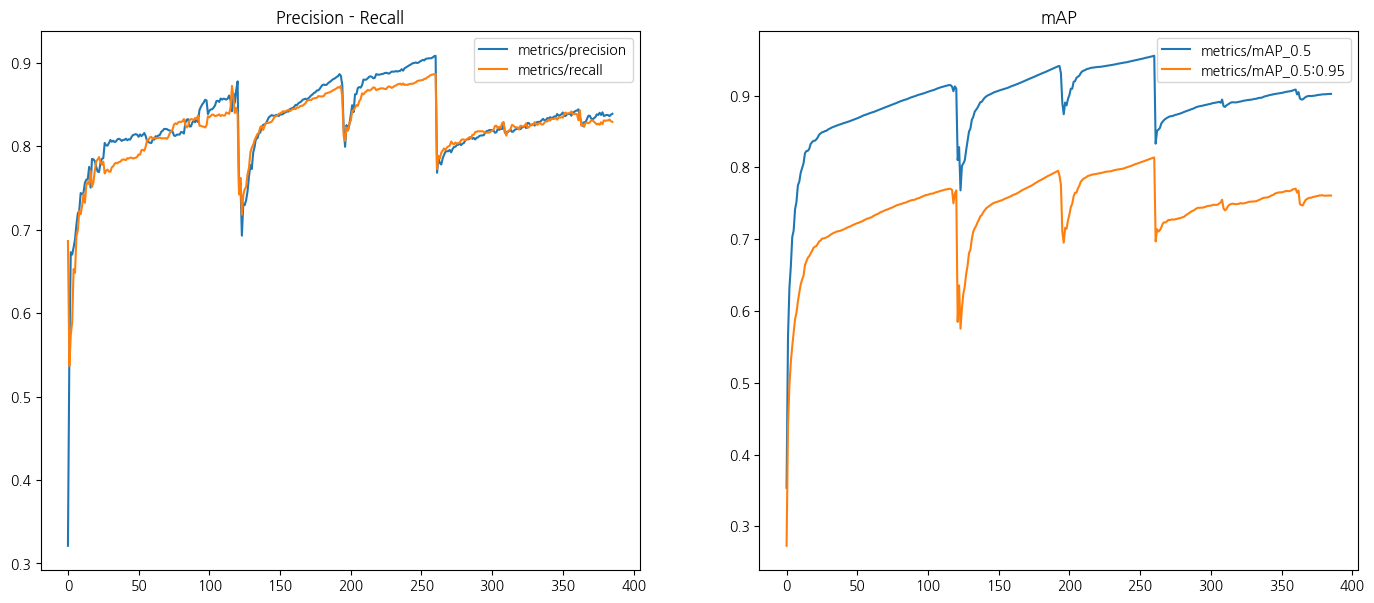

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(17, 7))
exp[["metrics/precision", "metrics/recall"]].plot(ax=ax[0])
ax[0].set_title("Precision - Recall")
exp[["metrics/mAP_0.5", "metrics/mAP_0.5:0.95"]].plot(ax=ax[1])
ax[1].set_title("mAP")
plt.show()

In [20]:
exp[["metrics/mAP_0.5", "metrics/mAP_0.5:0.95"]].sort_values(by="metrics/mAP_0.5:0.95").tail(1)

,metrics/mAP_0.5,metrics/mAP_0.5:0.95
260,0.95532,0.81366


## 3. Real Time Test

In [12]:
model = torch.hub.load("ultralytics/yolov5", "custom", path=r"./ee_model.pt", force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\nuyhc/.cache\torch\hub\master.zip
YOLOv5  2023-4-11 Python-3.9.16 torch-2.0.0 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
cap = cv2.VideoCapture(0)
# PATH = r"C:\Users\spec3\Downloads\켈리클락슨을 당황시킨 방탄 미국 팬들 함성.mp4"
# PATH = r"C:\Users\spec3\Downloads\[인생은 아름다워] '찐'관객 추천 영상.mp4"
# cap = cv2.VideoCapture(PATH) # Loaded video

thr = 0.5 # 검출 정확도
while cap.isOpened():
    ret, frame = cap.read()
    
    results = model(frame)
    cv2.imshow("Detection", np.squeeze(results.render()))
    # 라벨 출력
    labels = results.pandas().xyxy[0]
    detect_labels = labels[labels["confidence"]>thr]["name"]
    print(detect_labels.tolist())
    
    if cv2.waitKey(10)&0xFF==ord("q"): break
    
cap.release()
cv2.destroyAllWindows()